## Data Source / Following Along

https://archive.org/details/stackexchange

https://github.com/data-skeptic/feature-engineering-training

https://s3.amazonaws.com/dataskeptic-static/farcon/Posts.xml

# Loading our data to a dataframe

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xmltodict
import pandas as pd
import datetime
import bleach
import itertools
import math
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from scipy.stats.stats import pearsonr

In [2]:
fname = 'stats.stackexchange.com/Posts.xml'

In [3]:
import xml.etree.ElementTree
e = xml.etree.ElementTree.parse('stats.stackexchange.com/Posts.xml').getroot()

In [4]:
document_file = open(fname, "r")
original_doc = document_file.read()
document = xmltodict.parse(original_doc)

In [5]:
df = pd.DataFrame(document['posts']['row'])

In [6]:
df.columns = list(map(lambda x: x.replace('@', ''), df.columns))

In [7]:
pd.options.display.max_columns = 999

In [8]:
df.head()

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,LastEditorUserId,LastEditDate,CommunityOwnedDate,ParentId,ClosedDate,OwnerDisplayName,LastEditorDisplayName
0,1,1,15,2010-07-19T19:12:12.510,36,2475,<p>How should I elicit prior distributions fro...,8,2010-09-15T21:08:26.077,Eliciting priors from experts,<bayesian><prior><elicitation>,5,1,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,59,2010-07-19T19:12:57.157,29,22817,<p>In many different statistical methods there...,24,2016-06-27T06:44:40.147,What is normality?,<distributions><normality>,7,1,10,88,2010-08-07T17:56:44.800,NaN,NaN,NaN,NaN,NaN
2,3,1,5,2010-07-19T19:13:28.577,66,5746,<p>What are some valuable Statistical Analysis...,18,2013-05-27T14:48:36.927,What are some valuable Statistical Analysis op...,<software><open-source>,19,4,39,183,2011-02-12T05:50:03.667,2010-07-19T19:13:28.577,NaN,NaN,NaN,NaN
3,4,1,135,2010-07-19T19:13:31.617,17,25380,<p>I have two groups of data. Each with a dif...,23,2010-09-08T03:00:19.690,Assessing the significance of differences in d...,<distributions><statistical-significance>,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2,NaN,2010-07-19T19:14:43.050,86,NaN,"<p>The R-project</p>\n\n<p><a href=""http://www...",23,2010-07-19T19:21:15.063,NaN,NaN,NaN,3,NaN,23,2010-07-19T19:21:15.063,2010-07-19T19:14:43.050,3,NaN,NaN,NaN


## Data Cleaning

In [9]:
df['ViewCount'].fillna(0, inplace=True)
df['ViewCount'] = df['ViewCount'].astype(int)
df['Score'] = df['Score'].astype(int)
df['CreationDate'] = pd.to_datetime(df['CreationDate'])

In [10]:
df.groupby(['PostTypeId'])['ViewCount'].median()

PostTypeId
1    131
2      0
3      0
4      0
5      0
6      0
7      0
Name: ViewCount, dtype: int64

This field seems useless, let's get rid of it

In [11]:
del df['PostTypeId']

## Understanding Our Objective
We should expect that our result can be highly biased by right censorship.

In [12]:
df['cdt'] = df['CreationDate'].apply(lambda x: datetime.datetime.date(x))

In [13]:
g = pd.DataFrame(df.groupby(['cdt'])['ViewCount'].mean())
g.reset_index(inplace=True)
g.sort_values('cdt', inplace=True)

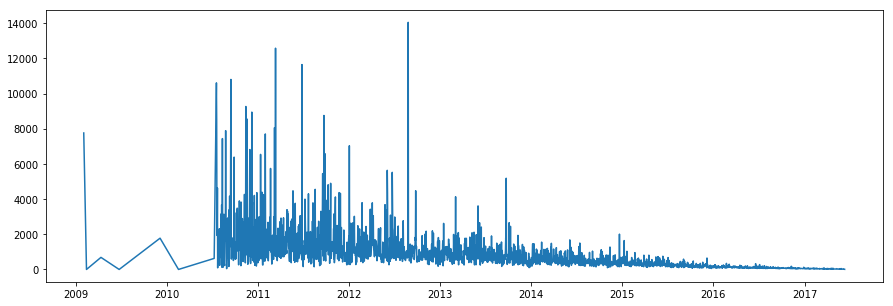

In [14]:
plt.figure(figsize=(15,5))
plt.plot(g['cdt'], g['ViewCount'])
plt.show()

In [15]:
g = pd.DataFrame(df.groupby(['ViewCount'])['Id'].count())
g.reset_index(inplace=True)
g['ViewCount'] = g['ViewCount'].astype(int)
g.sort_values('ViewCount', inplace=True)
g.columns = ['ViewCount', 'frequency']

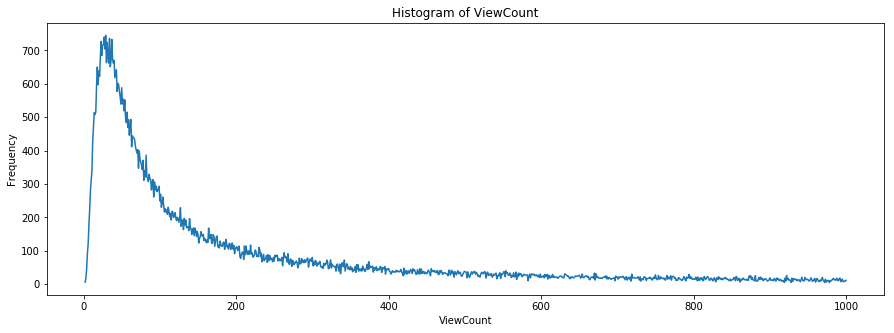

In [16]:
plt.figure(figsize=(15,5))
plt.plot(g['ViewCount'][1:1000], g['frequency'][1:1000])
plt.ylabel('Frequency')
plt.xlabel('ViewCount')
plt.title('Histogram of ViewCount')
plt.show()

In [17]:
del df['cdt']

What's up with the "score"?

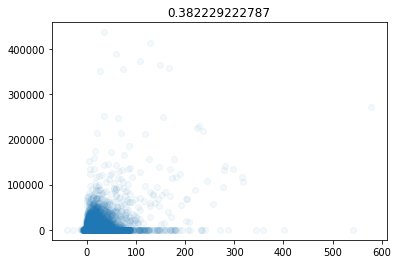

In [18]:
r2 = pearsonr(df['Score'], df['ViewCount'])[0]
plt.scatter(df['Score'], df['ViewCount'], alpha=0.05)
plt.title(r2)
plt.show()

## Remove possible Leakage Features
Let's be specific about what we want to predict.  Since our data is a snapshot in time, we can't predice "ViewCountTomorrow".  We should therefore predict given the merits of the question itself at the time of creation.

In [19]:
leakage_features = [
'Id','FavoriteCount','AnswerCount','CommentCount','AcceptedAnswerId'
,'LastEditDate','CommunityOwnedDate','ParentId','ClosedDate','LastEditorDisplayName'
,'LastActivityDate','LastEditorUserId','Score']

In [20]:
for lf in leakage_features:
    del df[lf]

## Tags

In [21]:
df['Tags'].head()

0               <bayesian><prior><elicitation>
1                   <distributions><normality>
2                      <software><open-source>
3    <distributions><statistical-significance>
4                                          NaN
Name: Tags, dtype: object

In [22]:
df['Tags'].fillna('', inplace=True)

How many types of Tags are there?

In [23]:
def tag2arr(s):
    if len(s) < 2:
        return []
    s = s[1:-1]
    arr = s.split('><')
    return arr

tags = df['Tags'].apply(tag2arr)

alltags = []
for arr in tags:
    alltags.extend(arr)

len(set(alltags))

1330

Let's make one quick feature from the metadata

In [24]:
df['tag_count'] = tags.apply(lambda x: len(x))

*What is the distribution of usage over these tags?*

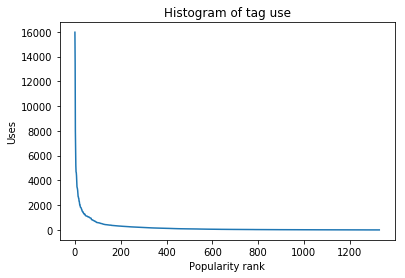

In [25]:
dfx = pd.DataFrame(pd.Series(alltags), columns=['tag'])
dfx['c'] = 1
g = pd.DataFrame(dfx.groupby(['tag'])['c'].sum())
g.reset_index(inplace=True)
g.sort_values('c', ascending=False, inplace=True)
g.index = np.arange(g.shape[0])
plt.plot(g['c'])
plt.title('Histogram of tag use')
plt.xlabel('Popularity rank')
plt.ylabel('Uses')
plt.show()

*Can we focus on just the popular ones and lump the long tail into "Other"?*

In [26]:
df['first_tag'] = tags.apply(lambda x: '' if len(x) == 0 else x[0])
ft = df.groupby(['first_tag']).aggregate({'ViewCount': np.median, 'Title': len})

In [27]:
ft.columns = ['uses', 'MedianViewCount']

In [28]:
dfx = ft[ft['uses'] > 20].copy()

In [29]:
dfx.sort_values('MedianViewCount', inplace=True)
dfx.reset_index(inplace=True)

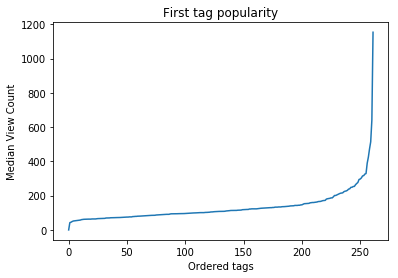

In [30]:
plt.plot(dfx['MedianViewCount'])
plt.xlabel('Ordered tags')
plt.ylabel('Median View Count')
plt.title('First tag popularity')
plt.show()

In [31]:
dfx.tail(20)

,first_tag,uses,MedianViewCount
242,effect-size,60,248.5
243,kolmogorov-smirnov,44,249.0
244,k-means,54,253.5
245,psychometrics,47,254.0
246,r,15943,264.0
247,ridge-regression,22,271.0
248,contingency-tables,34,277.0
249,scales,54,294.5
250,large-data,21,297.0
251,stata,296,303.5


In [32]:
dfx.sort_values('uses', inplace=True, ascending=False)
dfx.head(20)

,first_tag,uses,MedianViewCount
0,,102750,0.0
246,r,15943,264.0
162,regression,10981,124.0
178,machine-learning,6595,133.0
118,probability,4575,102.0
179,time-series,4553,133.0
117,hypothesis-testing,3599,102.0
166,distributions,2783,127.0
76,self-study,2610,87.5
169,correlation,2090,129.0


No tags == no views!

In [33]:
df[df['first_tag']=='']['ViewCount'].max()

0

Let's make a simple metadata feature

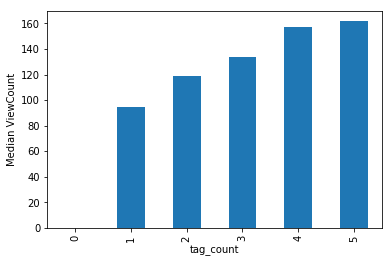

In [34]:
df.groupby(['tag_count'])['ViewCount'].median().plot(kind='bar')
plt.ylabel('Median ViewCount')
plt.show()

In [35]:
tc_dummies = pd.get_dummies(df['tag_count'])
tc_dummies.columns = list(map(lambda x: 'tc_' + str(x), tc_dummies.columns))
df = pd.concat([df, tc_dummies], axis=1)

In [36]:
del df['tag_count']
del df['Tags']

There's more to be done with tags, but let's move along and possibly come back to it.

## Handling long tailed categorical data
Let's create dummy variables for the top 20 features

In [37]:
dfx.sort_values('uses', inplace=True, ascending=False)
top_tags = dfx['first_tag'][1:20]

In [38]:
for tag in top_tags:
    df['tag_' + tag] = df['first_tag'] == tag

In [39]:
del df['first_tag']

## Time features

In [40]:
df['hod'] = df['CreationDate'].apply(lambda x: x.hour)

Naturally, there are trends in posting times, but is it a useful predictor?

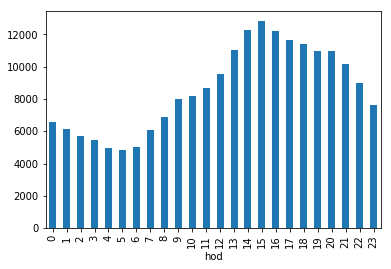

In [41]:
df.groupby(['hod'])['CreationDate'].count().plot(kind='bar')
plt.show()

The mean value says no!

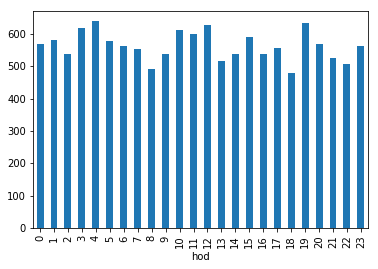

In [42]:
df.groupby(['hod'])['ViewCount'].mean().plot(kind='bar')
plt.show()

But the median says yes!

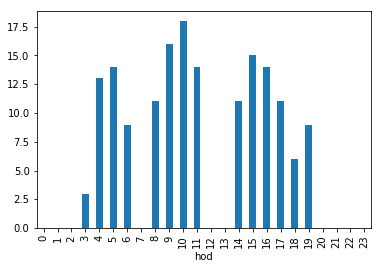

In [43]:
df.groupby(['hod'])['ViewCount'].median().plot(kind='bar')
plt.show()

In [44]:
df['dow'] = df['CreationDate'].apply(lambda x: x.dayofweek)

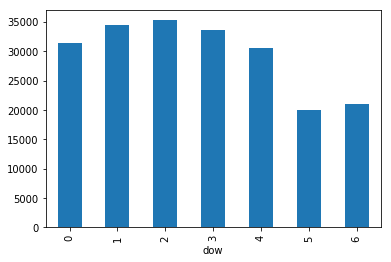

In [45]:
df.groupby(['dow'])['CreationDate'].count().plot(kind='bar')
plt.show()

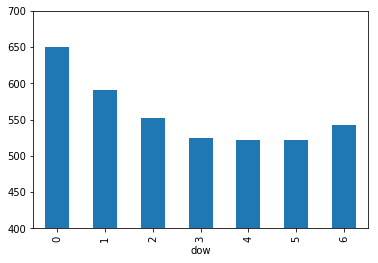

In [46]:
df.groupby(['dow'])['ViewCount'].mean().plot(kind='bar')
plt.ylim(400,700)
plt.show()

In [47]:
df['m'] = df['CreationDate'].apply(lambda x: x.month)

Month is a puzzling feature that we'll end up dropping

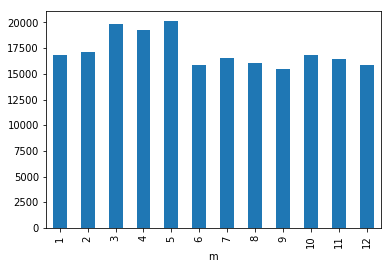

In [48]:
df.groupby(['m'])['CreationDate'].count().plot(kind='bar')
plt.show()

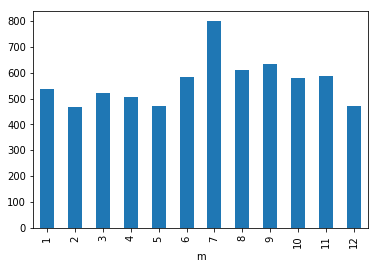

In [49]:
df.groupby(['m'])['ViewCount'].mean().plot(kind='bar')
plt.show()

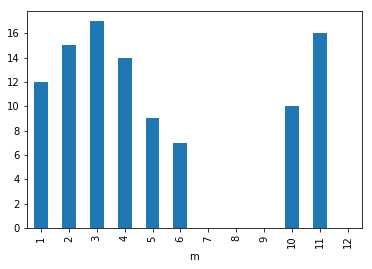

In [50]:
df.groupby(['m'])['ViewCount'].median().plot(kind='bar')
plt.show()

In [51]:
tc_dummies = pd.get_dummies(df['dow'])
tc_dummies.columns = list(map(lambda x: 'dow_' + str(x), tc_dummies.columns))
df = pd.concat([df, tc_dummies], axis=1)

In [52]:
tc_dummies = pd.get_dummies(df['hod'])
tc_dummies.columns = list(map(lambda x: 'hod_' + str(x), tc_dummies.columns))
df = pd.concat([df, tc_dummies], axis=1)

In [53]:
del df['dow']
del df['hod']
del df['m']

# Exploring the age of the post

In [54]:
last = df['CreationDate'].max()

In [55]:
df['days_since'] = (last - df['CreationDate']).apply(lambda x: int(x.days))

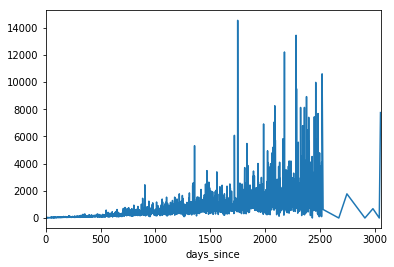

In [56]:
df.groupby(['days_since'])['ViewCount'].mean().plot()
plt.show()

In [57]:
df['months_since'] = (last - df['CreationDate']).apply(lambda x: int(x.days / 30))

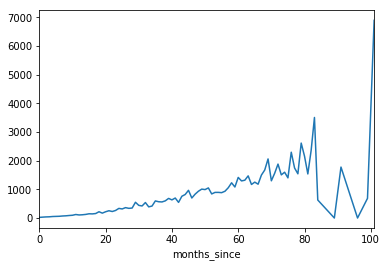

In [58]:
df.groupby(['months_since'])['ViewCount'].mean().plot()
plt.show()

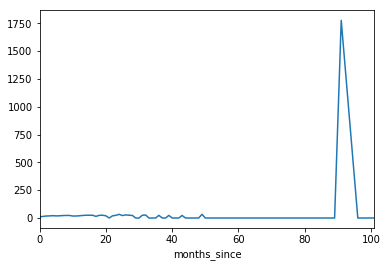

In [59]:
df.groupby(['months_since'])['ViewCount'].median().plot()
plt.show()

In [60]:
df['lvc'] = df['ViewCount'].apply(lambda x: math.log(x+1))

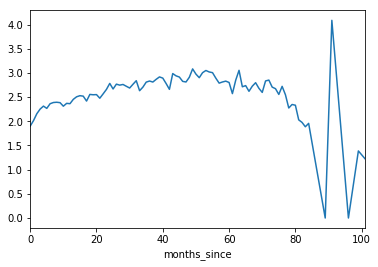

In [61]:
df.groupby(['months_since'])['lvc'].mean().plot()
plt.show()

In [62]:
df['d7'] = df['days_since'].apply(lambda x: x >= 0 and x < 7)
df['d30'] = df['days_since'].apply(lambda x: x >= 7 and x < 30)
df['d60'] = df['days_since'].apply(lambda x: x >= 30 and x < 90)
df['d90p'] = df['days_since'].apply(lambda x: x >= 90)

In [63]:
df.groupby(['d7', 'd30', 'd60', 'd90p'])['ViewCount'].mean()

d7     d30    d60    d90p 
False  False  False  True     599.607982
              True   False     34.342713
       True   False  False     22.848883
True   False  False  False     19.370682
Name: ViewCount, dtype: float64

In [64]:
del df['CreationDate']
del df['lvc']
del df['months_since']
del df['days_since']

## Textual meta-data

In [65]:
df['title_len'] = df['Title'].apply(lambda x: len(str(x)))
df['body_len'] = df['Body'].apply(lambda x: len(str(x)))

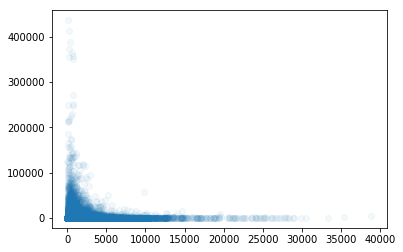

In [66]:
plt.scatter(df['body_len'], df['ViewCount'], alpha=0.05)
plt.show()

In [67]:
# Be patient!
df['Body2'] = df['Body'].apply(lambda x: bleach.clean(x, tags=[], attributes={}, styles=[], strip=True))

In [68]:
for bod in df['Body2'][0:10]:
    print(bod)
    print('------------------------------')

How should I elicit prior distributions from experts when fitting a Bayesian model?

------------------------------
In many different statistical methods there is an "assumption of normality".  What is "normality" and how do I know if there is normality?

------------------------------
What are some valuable Statistical Analysis open source projects available right now?

Edit: as pointed out by Sharpie, valuable could mean helping you get things done faster or more cheaply.

------------------------------
I have two groups of data.  Each with a different distribution of multiple variables.  I'm trying to determine if these two groups' distributions are different in a statistically significant way.  I have the data in both raw form and binned up in easier to deal with discrete categories with frequency counts in each.  

What tests/procedures/methods should I use to determine whether or not these two groups are significantly different and how do I do that in SAS or R (or Orange)?

-----

## Audience question: Should we really be focusing on the Body?  Any problems with this strategy?

In [69]:
def substringCount(haystack, needle):
    c = 0
    haystack = haystack.strip()
    i = 0
    while i != -1:
        i = haystack.find(needle, i+1)
        if i != -1:
            c += 1
    return c

In [70]:
df['body_newline_count'] = df['Body2'].apply(lambda x: substringCount(x, '\n'))

In [71]:
df['body_newline_count'] = df['body_newline_count'].apply(lambda x: math.log(x+1))

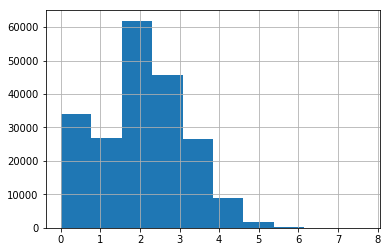

In [72]:
df['body_newline_count'].hist()

In [73]:
df['amt_html'] = 1.0 - df['Body2'].apply(len) / df['Body'].apply(len)

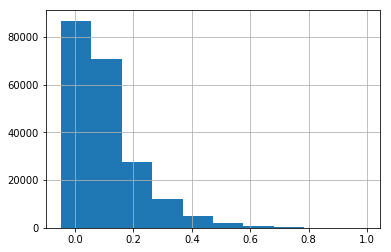

In [74]:
df['amt_html'].hist()
plt.show()

In [75]:
df['amt_html'] = df['amt_html'].apply(lambda x: math.log(x+1))

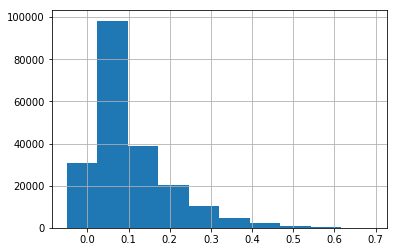

In [76]:
df['amt_html'].hist()
plt.show()

In [77]:
df['has_link'] = df['Body2'].apply(lambda x: x.find('http:') > 0 or x.find('https:') > 0)

In [78]:
df.groupby(['has_link'])['Body2'].count()

has_link
False    192844
True      13472
Name: Body2, dtype: int64

Under some circumstances, I'd add `has_latex` as a feature, but it seems to much like leakage here.

In [79]:
del df['Body']

In [80]:
del df['Body2']

## Crude User Modeling

In [81]:
len(set(df['OwnerDisplayName']))

2919

In [82]:
print(list(set(df['OwnerDisplayName']))[0:100])

[nan, 'user4288', 'miguelmalvarez', 'limp', 'ponadto', 'sinoTrinity', 'user1785104', 'Tobi', 'heropup', 'David Zhen', 'tree', 'user1911070', 'TomJ', 'Chris NH Street', 'iliasfl', 'user16775', 'fbrundu', "Giampiero D'Alessandro", 'user3507640', 'Miller Zhu', 'Jesse001', 'Ethan Bolker', 'rtelmore', 'user2637', 'prasenjit', 'tschmitty', 'Regenschein', 'Lowpar', 'lara.faelivrin', 'Jaap', 'Raymond Timmermans', 'Alexander Sobin', 'Ryno', 'MangoHands', 'user2964', 'user3583100', 'user3690', 'Addem', 'user664303', 'Sarra', 'Mamoud', 'Pieter Torrez', 'Worldsheep', 'hungh3', 'mr11', 'Predictor', 'Jim Clay', 'Gigili', 'Taoufiq Mouhcine', 'Lau99', 'Makro', 'user30490', 'user3632', 'user124644', 'user16731', 'tjnel', 'Braulio Quintero', 'Mickaël Perrier', 'Tim Nuttle', 'Miranda', 'user3897', 'Mash', 'Tomas T.', 'SAM', 'eterps', 'radek', 'David Rebelo', 'user2951', 'user7812', 'Robert Dodier', 'Danib90', 'Mike Henderson', 'Pedro Braz', 'user62545', 'Thierry', 'tdo', 'user3715', 'user2547406', 'Josh 

In [83]:
g = pd.DataFrame(df.groupby(['OwnerDisplayName']).aggregate({'ViewCount': {'m': np.mean, 'c': len}}))
g = g['ViewCount']
g.sort_values('m', ascending=False, inplace=True)
g.reset_index(inplace=True)
g.head(10)

/usr/local/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,OwnerDisplayName,m,c
0,user3636,356186.0,1
1,ritho,90993.0,1
2,alfa,77067.0,1
3,Durin,69085.0,1
4,Tawani,62084.0,1
5,Travis,53792.0,1
6,user333,42945.0,1
7,Arvin,42923.0,1
8,user3872,41785.0,1
9,sbg,36520.0,1


In [84]:
df[df['OwnerDisplayName']=='user3636']

,ViewCount,OwnerUserId,Title,OwnerDisplayName,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,tag_r,tag_regression,tag_machine-learning,tag_probability,tag_time-series,tag_hypothesis-testing,tag_distributions,tag_self-study,tag_correlation,tag_bayesian,tag_anova,tag_classification,tag_logistic,tag_statistical-significance,tag_clustering,tag_normal-distribution,tag_neural-networks,tag_confidence-interval,tag_mathematical-statistics,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,hod_0,hod_1,hod_2,hod_3,hod_4,hod_5,hod_6,hod_7,hod_8,hod_9,hod_10,hod_11,hod_12,hod_13,hod_14,hod_15,hod_16,hod_17,hod_18,hod_19,hod_20,hod_21,hod_22,hod_23,d7,d30,d60,d90p,title_len,body_len,body_newline_count,amt_html,has_link
7406,356186,NaN,How to choose between Pearson and Spearman cor...,user3636,0,0,0,1,0,0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,True,55,221,0.0,0.031183,False


In [85]:
df[df['OwnerDisplayName']=='ritho']

,ViewCount,OwnerUserId,Title,OwnerDisplayName,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,tag_r,tag_regression,tag_machine-learning,tag_probability,tag_time-series,tag_hypothesis-testing,tag_distributions,tag_self-study,tag_correlation,tag_bayesian,tag_anova,tag_classification,tag_logistic,tag_statistical-significance,tag_clustering,tag_normal-distribution,tag_neural-networks,tag_confidence-interval,tag_mathematical-statistics,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,hod_0,hod_1,hod_2,hod_3,hod_4,hod_5,hod_6,hod_7,hod_8,hod_9,hod_10,hod_11,hod_12,hod_13,hod_14,hod_15,hod_16,hod_17,hod_18,hod_19,hod_20,hod_21,hod_22,hod_23,d7,d30,d60,d90p,title_len,body_len,body_newline_count,amt_html,has_link
24726,90993,NaN,What is the reason why we use natural logarith...,ritho,0,1,0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,True,119,128,0.0,0.053245,False


In [86]:
g.sort_values('m', ascending=False, inplace=True)
g.head(10)

,OwnerDisplayName,m,c
0,user3636,356186.0,1
1,ritho,90993.0,1
2,alfa,77067.0,1
3,Durin,69085.0,1
4,Tawani,62084.0,1
5,Travis,53792.0,1
6,user333,42945.0,1
7,Arvin,42923.0,1
8,user3872,41785.0,1
9,sbg,36520.0,1


In [87]:
df['default_username'] = df['OwnerDisplayName'].apply(lambda x: str(x).find('user') == 0)

Other ideas

* Some sort of TF-IDF type score

* The number of previous questions from the user at the time a new question is asked

* External parsing of Title with API services (for example, see https://dataskeptic.com/blog/tools-and-techniques/2017/google-cloud-natural-language-api)

## Natural Language Processing

In [90]:
def ends_in_question(s):
    s = str(s)
    i = s.rfind('?')
    if i==-1:
        return False
    if len(s) - i < 5:
        return True
    return False

In [91]:
df['ends_in_qmark'] = df['Title'].apply(ends_in_question)

In [93]:
del df['Title']
del df['OwnerDisplayName']
del df['OwnerUserId']

# Further work

* More tag based features

* Accounting for Google organic results


## Model Building and Evaluation

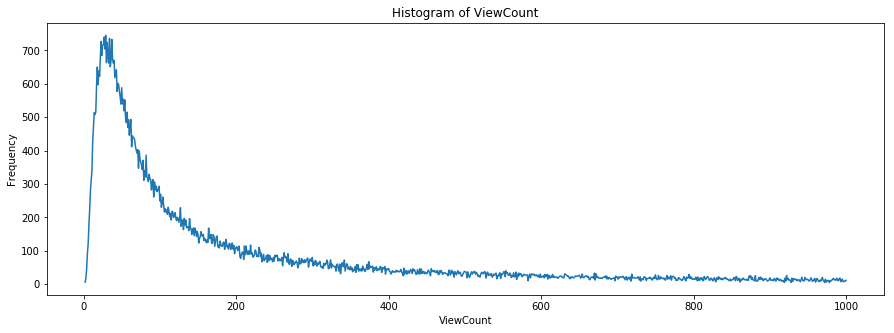

In [94]:
g = pd.DataFrame(df.groupby(['ViewCount'])['d7'].count())
g.reset_index(inplace=True)
g['ViewCount'] = g['ViewCount'].astype(int)
g.sort_values('ViewCount', inplace=True)
g.columns = ['ViewCount', 'frequency']

plt.figure(figsize=(15,5))
plt.plot(g['ViewCount'][1:1000], g['frequency'][1:1000])
plt.ylabel('Frequency')
plt.xlabel('ViewCount')
plt.title('Histogram of ViewCount')
plt.show()

In [95]:
df['v100'] = df['ViewCount'] > 100

In [96]:
kf = KFold(n_splits=5, random_state=None, shuffle=False)

In [97]:
features = df.columns.tolist()

In [98]:
features.remove('ViewCount')

In [99]:
features.remove('v100')

In [100]:
print(features)

['tc_0', 'tc_1', 'tc_2', 'tc_3', 'tc_4', 'tc_5', 'tag_r', 'tag_regression', 'tag_machine-learning', 'tag_probability', 'tag_time-series', 'tag_hypothesis-testing', 'tag_distributions', 'tag_self-study', 'tag_correlation', 'tag_bayesian', 'tag_anova', 'tag_classification', 'tag_logistic', 'tag_statistical-significance', 'tag_clustering', 'tag_normal-distribution', 'tag_neural-networks', 'tag_confidence-interval', 'tag_mathematical-statistics', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'hod_0', 'hod_1', 'hod_2', 'hod_3', 'hod_4', 'hod_5', 'hod_6', 'hod_7', 'hod_8', 'hod_9', 'hod_10', 'hod_11', 'hod_12', 'hod_13', 'hod_14', 'hod_15', 'hod_16', 'hod_17', 'hod_18', 'hod_19', 'hod_20', 'hod_21', 'hod_22', 'hod_23', 'd7', 'd30', 'd60', 'd90p', 'title_len', 'body_len', 'body_newline_count', 'amt_html', 'has_link', 'default_username', 'ends_in_qmark']


In [101]:
df = df.fillna(0)

In [102]:
X = df[features]
y = df['v100']

In [103]:
df.shape

(206316, 69)

In [104]:
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)

In [105]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[22093 15211]
 [  738  3221]]
Normalized confusion matrix
[[ 0.59  0.41]
 [ 0.19  0.81]]


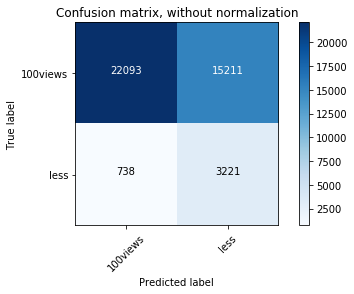

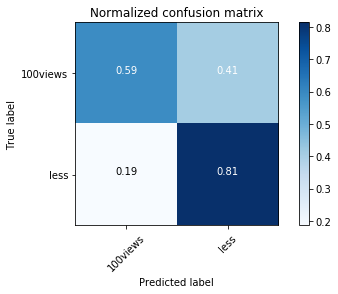

In [106]:
class_names = ['100views', 'less']

cnf_matrix = confusion_matrix(y_test, preds, labels=None, sample_weight=None)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

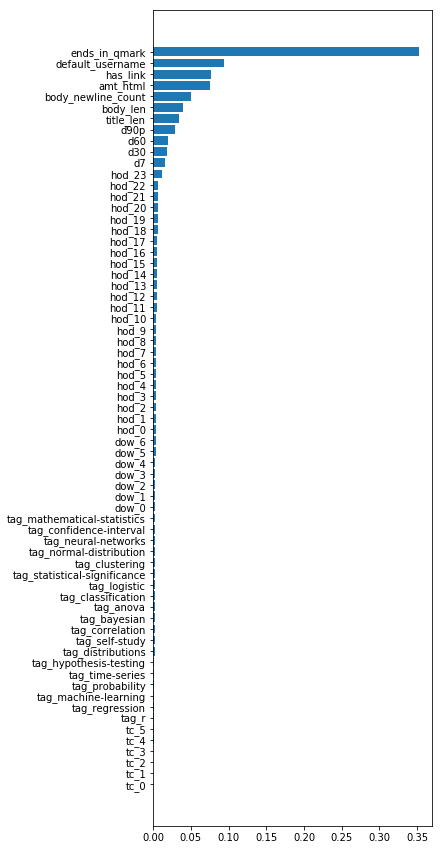

In [108]:
fi = rf.feature_importances_
dr = pd.DataFrame({'importance': fi})
dr.sort_values('importance', inplace=True, ascending=True)
dr.index = np.arange(dr.shape[0])
plt.figure(figsize=(5,15))
plt.barh(dr.index, dr['importance'])
x = np.arange(len(features))
plt.yticks(x,features)
plt.show()